**Data Collection**

In [ ]:
file_path = 'td-lte.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

file_path = 'essay.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    essay_data = file.read()

sepe = "*" * 200

text_data = essay_data + text_data

In [ ]:
text_data

"TD-LTE Modems:\nTD-LTE (Time Division-Long Term Evolution):\n\nTD-LTE is a standard for wireless broadband communication, representing a type of 4G LTE (Long-Term Evolution) technology.\nLTE is the fourth generation (4G) of wireless communication standards. It provides a significant improvement over 3G technologies in terms of data speed, network capacity, and latency.\nTD-LTE vs. FDD-LTE:TD LTE SIM and Modem Purchase Terms and Conditions\n\nTo use Irancell online store services, the Applicant shall accept and comply with the following terms and conditions:\n\n\nCustomer Obligations:\n\nBefore purchasing any TD-LTE modem, the Customer shall check Irancell network coverage in the intended area using the “coverage map” available on Irancell website.\u200c\n\nIn order to use Irancell services and products, the Customer shall accept the terms and conditions of the related service as well as the present terms and conditions.\n\nThe Customer shall be responsible to enter accurate and correc

**Data analyse**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


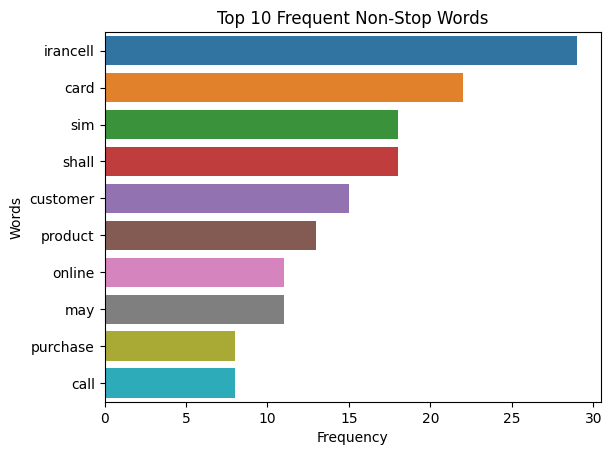

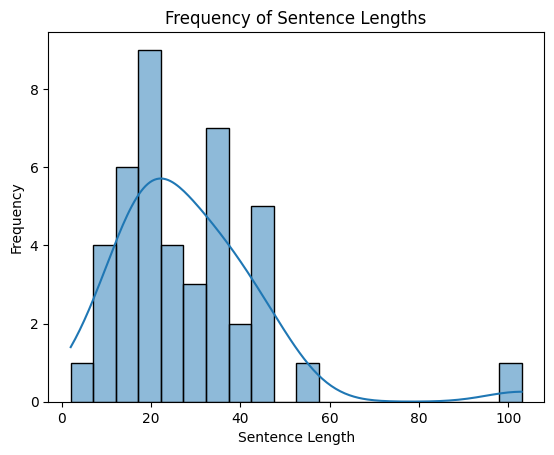

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return filtered_words

tokenized_text = preprocess_text(text_data)

word_freq = Counter(tokenized_text)
top_words = dict(word_freq.most_common(10))

# Plot the top 10 frequent non-stop words
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
plt.title('Top 10 Frequent Non-Stop Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

def sentence_lengths(text):
    sentences = text.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return [len(sentence.split()) for sentence in sentences]

sent_lengths = sentence_lengths(text_data)

# Plot the frequency of sentence lengths
sns.histplot(sent_lengths, bins=20, kde=True)
plt.title('Frequency of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

**Data preparation![tg_image_435197668.jpeg](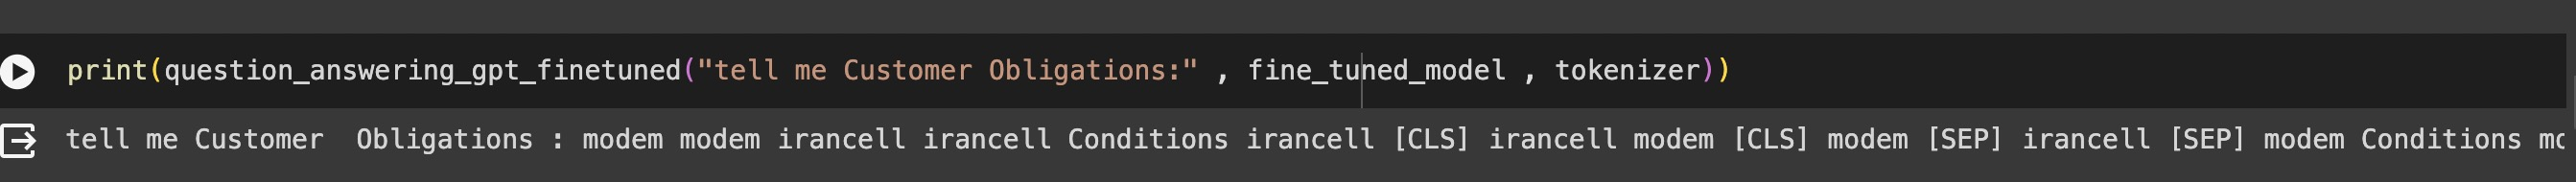![tg_image_435197668.jpeg](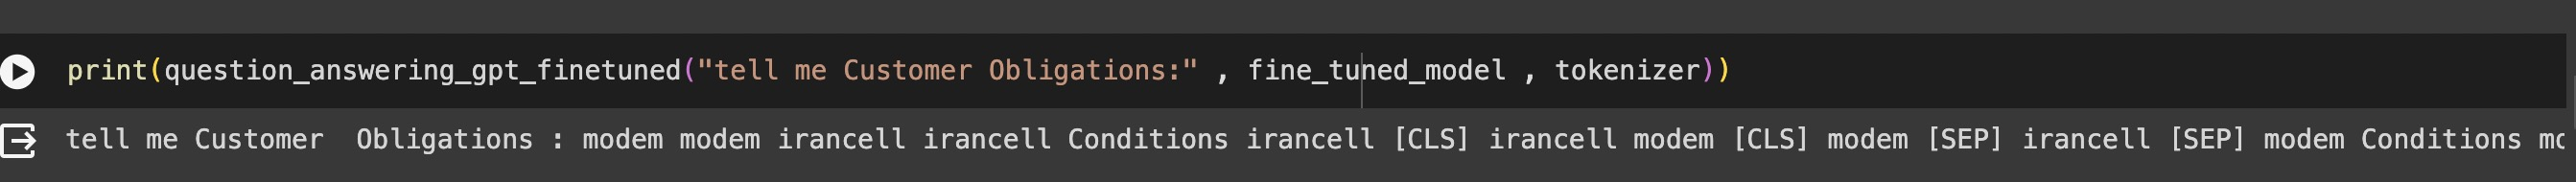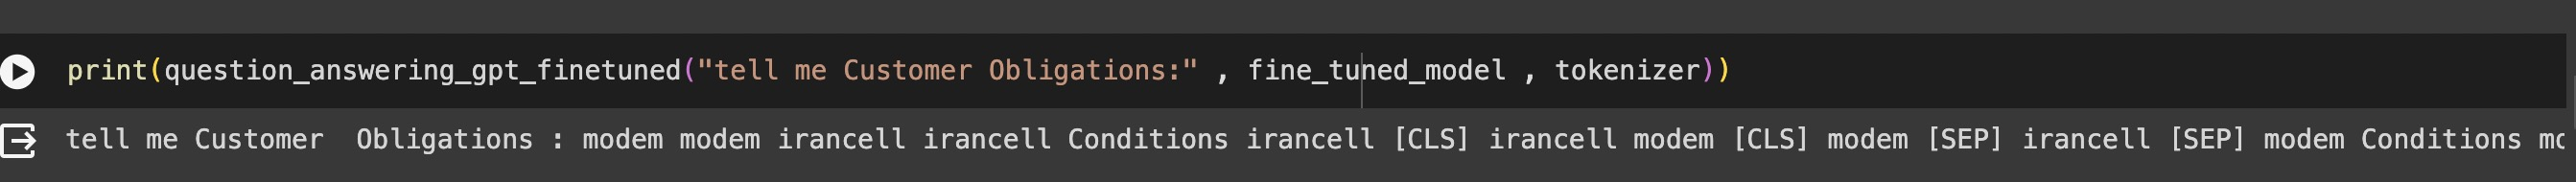))**

In [ ]:
import re
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, BertForQuestionAnswering, pipeline

def preprocess_data(text):
    text_without_commas = text.replace(',', '')
    text_without_extra_spaces = ' '.join(text_without_commas.split())
    return text_without_extra_spaces

# Preprocess the data
text_data = preprocess_data(text_data)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_cls(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    words = word_tokenize(text)

    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]
    #lemmatizing failed
    res = [word for word in words if word.isalnum() and word.lower() not in stop_words]

    preprocessed_text = ' '.join(res)

    return preprocessed_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Main Model**:

In [ ]:
#Creating subtexts for classification
block_size = 1200
step_size = (block_size * 3) // 4 #overlaping subtexts
subtexts = []

#both block size and step size are new hyperparameters which have been tuned


for i in range(0, len(text_data), step_size ):
    start_index = i
    end_index = min(i + block_size, len(text_data))

    # Expand subtext to the left to the nearest end of sentence
    while start_index > 0 and text_data[start_index] not in ['.', '!', '?']:
        start_index -= 1

    # Expand subtext to the right to the nearest end of sentence
    while end_index < len(text_data) and text_data[end_index - 1] not in ['.', '!', '?']:
        end_index += 1

    subtext = text_data[start_index:end_index].strip()
    subtexts.append(subtext)

main_subtexts = subtexts.copy()
subtexts = [preprocess_cls(text) for text in subtexts]

#Fine-tuning the text classification
model_name = 'bert-base-uncased' #large bert took all RAM
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(subtexts))

labels = np.array(range(len(subtexts)))

#tokenizing input texts
encoded_inputs = tokenizer(subtexts, padding=True, truncation=True, return_tensors='pt')
input_ids_pt = encoded_inputs['input_ids']
attention_mask_pt = encoded_inputs['attention_mask']

labels_pt = torch.tensor(labels)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) #tuned
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(4):
    outputs = model(input_ids_pt, attention_mask=attention_mask_pt)
    loss = criterion(outputs.logits, labels_pt)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Question answering models , squad pretrained
qa_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=tokenizer, device=0)  # Set device to GPU if available


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def question_answering(question):
    # Classify the question
    prepared_q = preprocess_cls(question)
    #prepared_q = question
    question_encoding = tokenizer(prepared_q, return_tensors='pt', padding=True, truncation=True)
    input_ids_pt = question_encoding['input_ids']
    attention_mask_pt = question_encoding['attention_mask']

    outputs = model(input_ids_pt, attention_mask=attention_mask_pt)
    predicted_class_index = torch.argmax(outputs.logits)
    predicted_class = labels[predicted_class_index.numpy()]

    #getting the answer using the QA model
    answer_input = f"{predicted_class}. {main_subtexts[predicted_class_index.numpy()]}"  # Use the predicted class as context
    qa_output = qa_pipeline(question=question, context=answer_input)

    return {
        "Question": question,
        "Predicted Class": predicted_class,
        "Answer": qa_output['answer']
    }

# Example question
question_example = "What is customer Obligations?"

# Call the question answering function
result = question_answering(question_example)

# Print the results
print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])

Question: What is customer Obligations?
Predicted Class: 0
Answer: Before purchasing any TD-LTE modem


In [ ]:
question_example = "the product will be sent through regular delivery within how many days?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])

Question: the product will be sent through regular delivery within how many days?
Predicted Class: 8
Answer: 7


In [ ]:
question_example = "When cas customers cancel their order?" #there is even typo in question

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])

Question: When cas customers cancel their order?
Predicted Class: 5
Answer: 30 days after purchase.‌‌


In [ ]:
print("the part answer is in:" , subtexts[result["Predicted Class"]])

the part answer is in: ask refund purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online chat Call Center Customers purchase SIM Card Irancell Online Stores may return SIM Card within 30 days ask returning SIM Card purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online Call Center amounts paid using bank card connected centralized account refunded Payments made using gift card similar cards refundable Irancell undertakes responsibility returning return modems TD FD Support possible due provision mobile fixed internet services Limit Number SIM Cards Owned Customers Please note according CRA instructions possible register activate maximum ten 10 SIM Cards Iranian natural persons three 3 SIM Cards natural SIM Card owner decides transfer ownership SIM Card another person follow Irancell regulations re

In [ ]:
question_example = "how to call irancell?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: how to call irancell?
Predicted Class: 8
Answer: by dialing 707
the part answer is in: postman arrives announced address Subscriber present Subscriber may call Irancell Call Center dialing 707 Irancell lines 09377070000 lines ask delivery product postman Express Delivery choose express delivery receive product within selected time period need present announced address otherwise product sent regular delivery within 7 days


In [ ]:
question_example = "How is the payment method?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: How is the payment method?
Predicted Class: 5
Answer: bank card connected to a centralized account
the part answer is in: ask refund purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online chat Call Center Customers purchase SIM Card Irancell Online Stores may return SIM Card within 30 days ask returning SIM Card purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online Call Center amounts paid using bank card connected centralized account refunded Payments made using gift card similar cards refundable Irancell undertakes responsibility returning return modems TD FD Support possible due provision mobile fixed internet services Limit Number SIM Cards Owned Customers Please note according CRA instructions possible register activate maximum ten 10 SIM Cards Iranian natural persons three 3 SIM C

In [ ]:
question_example = "how Can i get my money back after purchase?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

question_example = "when Can i get my money back after purchase?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: how Can i get my money back after purchase?
Predicted Class: 5
Answer: Irancell Online Stores
the part answer is in: ask refund purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online chat Call Center Customers purchase SIM Card Irancell Online Stores may return SIM Card within 30 days ask returning SIM Card purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online Call Center amounts paid using bank card connected centralized account refunded Payments made using gift card similar cards refundable Irancell undertakes responsibility returning return modems TD FD Support possible due provision mobile fixed internet services Limit Number SIM Cards Owned Customers Please note according CRA instructions possible register activate maximum ten 10 SIM Cards Iranian natural persons three 3 SIM Cards 

In [ ]:
question_example = "is passport acceptable ?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: is passport acceptable ?
Predicted Class: 5
Answer: they should follow all Irancell's regulations in this regard.
the part answer is in: ask refund purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online chat Call Center Customers purchase SIM Card Irancell Online Stores may return SIM Card within 30 days ask returning SIM Card purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online Call Center amounts paid using bank card connected centralized account refunded Payments made using gift card similar cards refundable Irancell undertakes responsibility returning return modems TD FD Support possible due provision mobile fixed internet services Limit Number SIM Cards Owned Customers Please note according CRA instructions possible register activate maximum ten 10 SIM Cards Iranian natural person

In [ ]:
question_example = "how many sim cards can a customer have?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: how many sim cards can a customer have?
Predicted Class: 5
Answer: ten (10) SIM Cards
the part answer is in: ask refund purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online chat Call Center Customers purchase SIM Card Irancell Online Stores may return SIM Card within 30 days ask returning SIM Card purchaser person whose name SIM Card registered may contact Irancell Call Center dialing 707 Irancell lines 09377070000 lines may raise request online Call Center amounts paid using bank card connected centralized account refunded Payments made using gift card similar cards refundable Irancell undertakes responsibility returning return modems TD FD Support possible due provision mobile fixed internet services Limit Number SIM Cards Owned Customers Please note according CRA instructions possible register activate maximum ten 10 SIM Cards Iranian natural persons three 3 SIM Cards natural 

In [ ]:
question_example = "how Can i get my money back after purchase?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: how Can i get my money back after purchase?
Predicted Class: 7
Answer: call Irancell Call Center
the part answer is in: Valid identity documents Iranian nationals shall include one following Smart National ID Card New birth certificate containing digital photo National ID birth certificate lacking photo shall valid Old National ID Card together smart National ID Card receipt sealed ICT service center electronic services counter post office civil registry certificate approved civil registry National ID certificate valid identity document foreign nationals shall include one following valid passport Amayesh card identity card green card VIP residence permit foreign nationals documents visa shall acceptable postman arrives announced address Subscriber present Subscriber may call Irancell Call Center dialing 707 Irancell lines 09377070000 lines ask delivery product postman Express Delivery choose express delivery receive product within selected time period need present announced a

In [ ]:
question_example = "What is 4g?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: What is 4g?
Predicted Class: 0
Answer: wireless communication standards.
the part answer is in: Modems Time Term Evolution standard wireless broadband communication representing type 4G LTE Evolution technology LTE fourth generation 4G wireless communication standards provides significant improvement 3G technologies terms data speed network capacity latency TD LTE SIM Modem Purchase Terms Conditions use Irancell online store services Applicant shall accept comply following terms conditions Customer Obligations purchasing modem Customer shall check Irancell network coverage intended area using coverage map available Irancell order use Irancell services products Customer shall accept terms conditions related service well present terms conditions Customer shall responsible enter accurate correct identity information purchasing service product case inaccurate information entered Customer central authentication system able generate reference number therefore service registration a

In [ ]:
question_example = "How is td-lte model?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: How is td-lte model?
Predicted Class: 0
Answer: 4G LTE (Long-Term Evolution) technology.
the part answer is in: Modems Time Term Evolution standard wireless broadband communication representing type 4G LTE Evolution technology LTE fourth generation 4G wireless communication standards provides significant improvement 3G technologies terms data speed network capacity latency TD LTE SIM Modem Purchase Terms Conditions use Irancell online store services Applicant shall accept comply following terms conditions Customer Obligations purchasing modem Customer shall check Irancell network coverage intended area using coverage map available Irancell order use Irancell services products Customer shall accept terms conditions related service well present terms conditions Customer shall responsible enter accurate correct identity information purchasing service product case inaccurate information entered Customer central authentication system able generate reference number therefore servic

In [ ]:
question_example = "how to call irancell?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: how to call irancell?
Predicted Class: 8
Answer: by dialing 707
the part answer is in: postman arrives announced address Subscriber present Subscriber may call Irancell Call Center dialing 707 Irancell lines 09377070000 lines ask delivery product postman Express Delivery choose express delivery receive product within selected time period need present announced address otherwise product sent regular delivery within 7 days


In [ ]:
question_example = "what kind of sim cards supporg 7g internet of england country?"

result = question_answering(question_example)

print("Question:", result["Question"])
print("Predicted Class:", result["Predicted Class"])
print("Answer:", result["Answer"])
print("the part answer is in:" , subtexts[result["Predicted Class"]])

Question: what kind of sim cards supporg 7g internet of england country?
Predicted Class: 7
Answer: Smart National ID Card
the part answer is in: Valid identity documents Iranian nationals shall include one following Smart National ID Card New birth certificate containing digital photo National ID birth certificate lacking photo shall valid Old National ID Card together smart National ID Card receipt sealed ICT service center electronic services counter post office civil registry certificate approved civil registry National ID certificate valid identity document foreign nationals shall include one following valid passport Amayesh card identity card green card VIP residence permit foreign nationals documents visa shall acceptable postman arrives announced address Subscriber present Subscriber may call Irancell Call Center dialing 707 Irancell lines 09377070000 lines ask delivery product postman Express Delivery choose express delivery receive product within selected time period need pre



---



---



**Other models and methods**

In [ ]:
#trying longformer not interesting result
from transformers import LongformerForQuestionAnswering, LongformerTokenizer

def answer_question_longformer(question, context, model, tokenizer, max_seq_length=4096):
    inputs = tokenizer(question, context, return_tensors="pt", max_length=max_seq_length, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)

    start_idx = torch.argmax(outputs.start_logits, dim=1).item()
    end_idx = torch.argmax(outputs.end_logits, dim=1).item()

    answer_span = tokenizer.decode(inputs["input_ids"][0, start_idx:end_idx+1])

    return answer_span

longformer_model = LongformerForQuestionAnswering.from_pretrained('allenai/longformer-base-4096')
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForQuestionAnswering were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
question = "What is The Limit on Number of SIM Cards Owned by Customers:‌‌?"
context = text_data

# Answer the question with Longformer
answer = answer_question_longformer(question, context, longformer_model, longformer_tokenizer)

print("Answer:", answer)

Answer:  of residence. Please be careful while entering the postal code and other information since the information recorded in your file (in Irancell system) is the basis for providing you with all Irancell gifts and services. Irancell Obligations: Irancell undertakes to deliver to the Customer the purchased product



---



In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
#gpt model , suddenly didn't work due to index out of range problem
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

model = GPT2LMHeadModel.from_pretrained(model_name)



key_words = ['irancell' , 'modem' , 'td-lte' , 'Terms' , 'Conditions' , 'Obligations' , 'Irancell' , 'User' , 'Customers']
print(len(tokenizer))
tokenizer.add_tokens(key_words)
print(len(tokenizer))

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print("[PAD] Token ID:", tokenizer.pad_token_id)
print("Special Tokens:", tokenizer.special_tokens_map)

# special_tokens = ['[CLS]', '[SEP]', '[PAD]']
# tokenizer.add_tokens(special_tokens)
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
file_path = 'td-lte.txt'
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=file_path,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

training_args = TrainingArguments(
    output_dir="./gpt_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=0.000109
)

trainer = Trainer(
    model=GPT2LMHeadModel.from_pretrained(model_name),
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()

model.save_pretrained("./gpt_finetuned")



50257
50265
[PAD] Token ID: 50265
Special Tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]'}


/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


IndexError: ignored

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.resize_token_embeddings(len(tokenizer))
def question_answering_gpt_finetuned(question, model, tokenizer, max_length=400, num_beams=5, no_repeat_ngram_size=2):
    input_ids = tokenizer.encode(question, return_tensors="pt", padding=True, truncation=True, max_length=256)
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        model.eval()

        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            pad_token_id=tokenizer.eos_token_id,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
        )

    generated_answer = tokenizer.decode(output[0], skip_special_tokens=False)
    return generated_answer

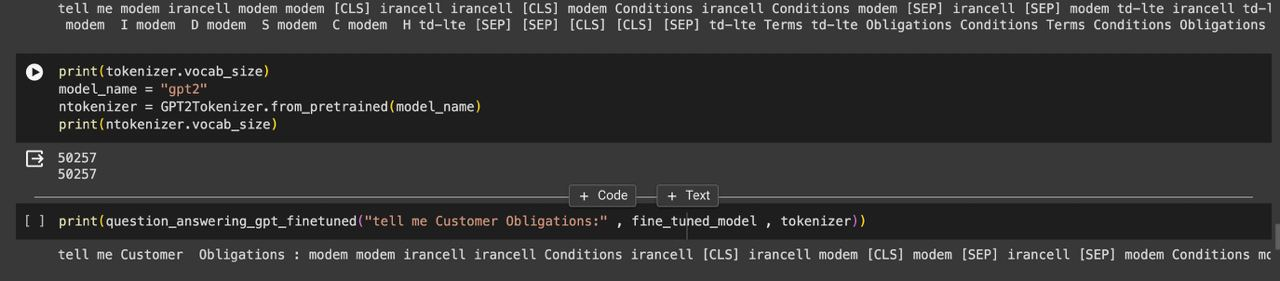



---



---



In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel
import torch
def question_answering_t5(question):
    model_name_t5 = "t5-small"
    tokenizer_t5 = T5Tokenizer.from_pretrained(model_name_t5)
    model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)

    input_text = f"answer: {question}"
    input_ids = tokenizer_t5.encode(input_text, return_tensors="pt")

    with torch.no_grad():
        output = model_t5.generate(input_ids)

    generated_answer = tokenizer_t5.decode(output[0], skip_special_tokens=True)
    return generated_answer

def question_answering_gpt(question):
    model_name_gpt = "gpt2-medium"
    tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name_gpt)
    model_gpt = GPT2LMHeadModel.from_pretrained(model_name_gpt)

    input_ids = tokenizer_gpt.encode(question, return_tensors="pt")

    with torch.no_grad():
        output = model_gpt.generate(
            input_ids,
            max_length=50,
            attention_mask=torch.ones_like(input_ids),
            pad_token_id=tokenizer_gpt.eos_token_id,
            num_beams=5,
            no_repeat_ngram_size=2
        )

    generated_answer = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
    return generated_answer

answer_gpt = question_answering_gpt(question_example)



vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Answer using T5:

Answer using GPT:
What do you think about ducks? Let us know in the comments below.


In [ ]:
print(question_answering_gpt("explain mc donald"))

explain mc donald_trump_says_i_will_be_the_next_president_of_us_and_we_are_going_to_make_a_great_country.html https://www.


In [ ]:
print(question_answering_t5("explain mc donald"))

ImportError: ignored



---



---



In [ ]:
#Roberta
import torch
from transformers import RobertaTokenizer, RobertaForQuestionAnswering, AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import re
from transformers import TFAutoModelForQuestionAnswering

with open('td-lte.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForQuestionAnswering.from_pretrained('roberta-base')

dummy_question = "What is this?"
dummy_answer = "This is a dummy answer."
dummy_input = tokenizer(dummy_question, dummy_answer, return_tensors='pt')
dummy_output = model(**dummy_input, start_positions=torch.tensor([1]), end_positions=torch.tensor([1]))

def extract_sentences(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return sentences

sentences = extract_sentences(text_data)

qa_pairs = []
for sentence in sentences:
    question = f"What is mentioned in the context of: '{sentence}'?"
    answer = sentence
    qa_pairs.append({"question": question, "answer": answer})

tokenized_qa_pairs = tokenizer(
    [qa_pair["question"] for qa_pair in qa_pairs],
    [qa_pair["answer"] for qa_pair in qa_pairs],
    return_tensors='pt',
    max_length=512,
    truncation=True,
    padding='max_length',
)

class QADataset(Dataset):
    def __init__(self, tokenized_qa_pairs):
        self.tokenized_qa_pairs = tokenized_qa_pairs

    def __len__(self):
        return len(self.tokenized_qa_pairs["input_ids"])

    def __getitem__(self, index):
        return {key: self.tokenized_qa_pairs[key][index] for key in self.tokenized_qa_pairs.keys()}

dataset = QADataset(tokenized_qa_pairs)

dataloader = DataLoader(dataset, batch_size=4 , shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        for key in batch:
            batch[key] = batch[key].to(device)

        if "end_positions" not in batch or batch["end_positions"].sum() == 0:
            continue

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def question_answering(question, context, model, tokenizer):
    inputs = tokenizer(
        question,
        context,
        return_tensors='pt',
        max_length=256,
        truncation=True,
        padding='max_length',
    )
    outputs = model(**inputs)
    start_idx = torch.argmax(outputs['start_logits'], dim=1).item()
    end_idx = torch.argmax(outputs['end_logits'], dim=1).item() + 1
    answer = tokenizer.decode(inputs['input_ids'][0, start_idx:end_idx], skip_special_tokens=True)
    return answer

question_example = "What is user obligations?"
answer_example = question_answering(question_example, text_data, model, tokenizer)
print(f"Answer: {answer_example}")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 6/6 [00:00<00:00, 3264.05it/s]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Answer: 


In [ ]:
question_answering("how many sim cards a user can buy ?", text_data, model, tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


''